In [1]:
import pandas as pd

In [2]:
data = pd.read_csv("k562.gwas_variants.tsv", sep="\t", header=0)

/users/anusri/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3331: DtypeWarning: Columns (9,10,11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [3]:
data.columns

Index(['chr', 'pos', 'allele1', 'allele2', 'variant_id',
       'ENCSR637XSC.logfc.mean', 'ENCSR637XSC.sign_jsd.mean',
       'ENCSR637XSC.abs_logfc_x_jsd_x_max_percentile.mean',
       'ENCSR637XSC.abs_logfc_x_jsd_x_max_percentile.mean.pval', 'rsid',
       'traits', 'IDs', 'maxPIP', 'ENCSR000EMT.logfc.mean',
       'ENCSR000EMT.sign_jsd.mean',
       'ENCSR000EMT.abs_logfc_x_jsd_x_max_percentile.mean',
       'ENCSR000EMT.abs_logfc_x_jsd_x_max_percentile.mean.pval'],
      dtype='object')

In [4]:
data.head(2)

,chr,pos,allele1,allele2,variant_id,ENCSR637XSC.logfc.mean,ENCSR637XSC.sign_jsd.mean,ENCSR637XSC.abs_logfc_x_jsd_x_max_percentile.mean,ENCSR637XSC.abs_logfc_x_jsd_x_max_percentile.mean.pval,rsid,traits,IDs,maxPIP,ENCSR000EMT.logfc.mean,ENCSR000EMT.sign_jsd.mean,ENCSR000EMT.abs_logfc_x_jsd_x_max_percentile.mean,ENCSR000EMT.abs_logfc_x_jsd_x_max_percentile.mean.pval
0,chr1,10352,T,TA,rs150218945,-0.036835,-0.016749,0.000497,0.055084,NaN,NaN,NaN,NaN,0.004799,0.013399,0.000059,0.219019
1,chr1,11012,C,G,rs544419019,-0.010156,-0.022090,0.000218,0.116639,NaN,NaN,NaN,NaN,0.008337,0.031942,0.000489,0.061075


In [5]:
import matplotlib


matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure

plt.rcParams['figure.figsize'] = [12, 10]

def plot_enrichment_curves(df, compare_score, model_score, output_file, compare_score_ascending=False, model_score_ascending=True,
                           thresh_list=[0.5, 0.1, 0.05, 0.01, 0.005, 0.001, 0.0005, 0.0001], subsample=False, ymax='auto', debug=False):
    by_thresh_dict = {'score':[], 'ratio':[], 'thresh':[]}
    
    for thresh in thresh_list:
        df[compare_score].fillna(0, inplace=True)
        sample_df = df.sort_values(by=[compare_score, model_score], ascending=[False, True])
        #print(sample_df.head())
        #print(sample_df.tail())
        print(sum(sample_df[model_score] < thresh))
        ratio = len(sample_df.loc[sample_df[model_score] < thresh]) / len(sample_df)
        sample_df['sig'] = sample_df[model_score].apply(lambda x: x < thresh)
        sample_df['expected'] = [ratio] * len(sample_df)
        expected = sample_df['expected'].cumsum().tolist()
        observed = sample_df['sig'].cumsum().tolist()
        
        enrich_ratio = np.array(observed) / np.array(expected)
        compare_vals = sample_df[compare_score].tolist()
        enrich_ratio = enrich_ratio.tolist()
        assert len(compare_vals) == len(enrich_ratio)
        by_thresh_dict['ratio'].extend(enrich_ratio)
        by_thresh_dict['score'].extend(compare_vals)
        by_thresh_dict['thresh'].extend([thresh] * len(sample_df))
        
        if debug:
            print(thresh)
            print('Expected:', expected[:10])
            print('Observed:', observed[:10])
            print('Ratio:', enrich_ratio[:10])
            print('Compare Scores:', compare_vals[:10])
            print()
        
    by_thresh_df = pd.DataFrame(by_thresh_dict)
    by_thresh_df.sort_values(by=['score'], ascending=False, inplace=True)
    return by_thresh_df

In [7]:
import numpy as np
import seaborn as sns

data[np.isnan(data['maxPIP'])]['maxPIP'] = 0

by_thresh_df = plot_enrichment_curves(data,
                       compare_score='maxPIP', model_score='ENCSR637XSC.abs_logfc_x_jsd_x_max_percentile.mean.pval',
                       compare_score_ascending=False, model_score_ascending=True, output_file="bloodtraits_abs_logfc_x_jsd_x_max_percentile.pdf")

4986998
728384
336306
66207
33135
6280
3087
635


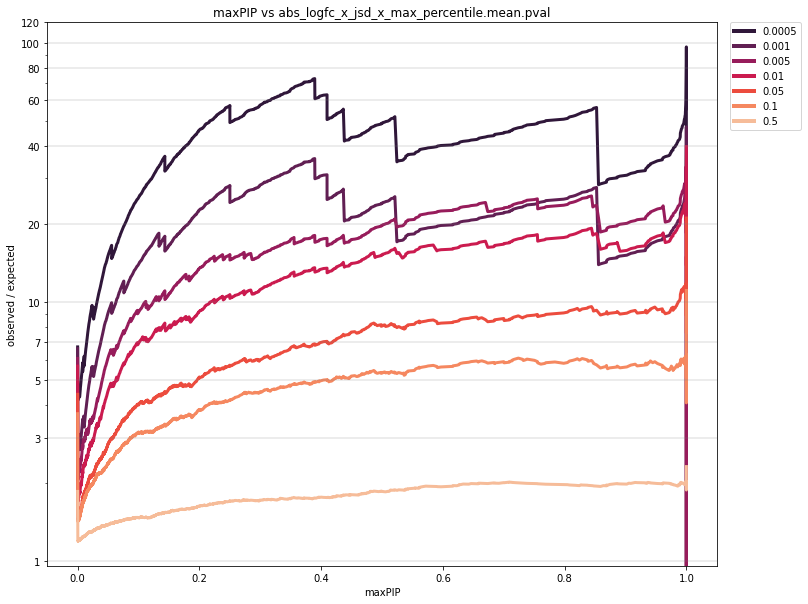

In [8]:
0.0001
n_by_thresh_df = by_thresh_df
by_thresh_df = n_by_thresh_df[~n_by_thresh_df['thresh'].isin([0.0001])]

import matplotlib

import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

compare_score='maxPIP'
model_score='ENCSR637XSC.abs_logfc_x_jsd_x_max_percentile.mean.pval'

ax = sns.lineplot(data=by_thresh_df, x='score', y='ratio', linewidth=3, ci=None,
                  hue='thresh', palette=sns.color_palette('rocket', 7))
leg = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
for line in leg.get_lines():
    line.set_linewidth(4)
ax.set(title=compare_score + ' vs ' + model_score, xlabel=compare_score, ylabel='observed / expected')

ax.set(yscale='log')
ax.set_yticks([1,  3,  5, 7, 10, 20, 40, 60, 80, 100, 120])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.axhline(y=1, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=3, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=5, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=7, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=10, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=20, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=40, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=60, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=80, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=100, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=120, color='grey', linestyle='-', alpha=0.2)



In [9]:
import numpy as np
import seaborn as sns

data[np.isnan(data['maxPIP'])]['maxPIP'] = 0

by_thresh_df = plot_enrichment_curves(data,
                       compare_score='maxPIP', model_score='ENCSR000EMT.abs_logfc_x_jsd_x_max_percentile.mean.pval',
                       compare_score_ascending=False, model_score_ascending=True, output_file="bloodtraits_abs_logfc_x_jsd_x_max_percentile.pdf")

5890175
1002134
487006
94517
46388
8834
4209
811


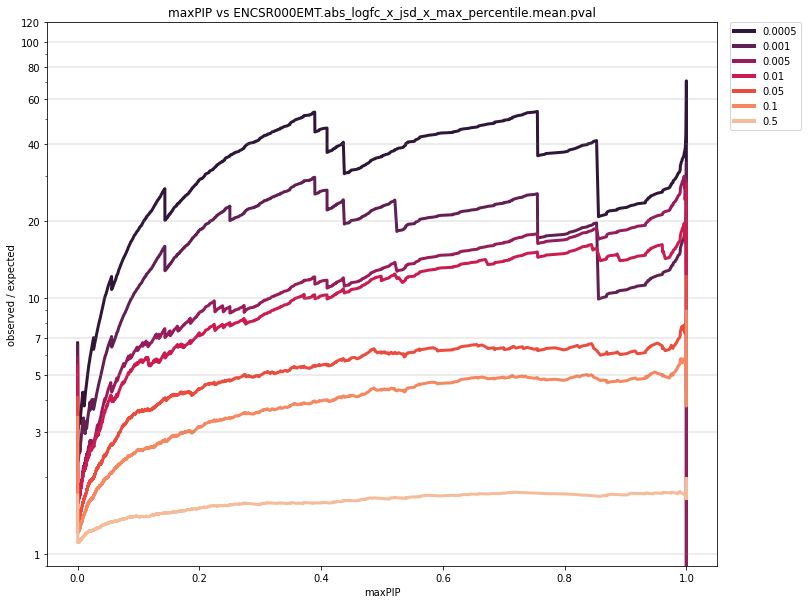

In [10]:
0.0001
n_by_thresh_df = by_thresh_df
by_thresh_df = n_by_thresh_df[~n_by_thresh_df['thresh'].isin([0.0001])]

import matplotlib

import seaborn as sns

matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42 

compare_score='maxPIP'
model_score='ENCSR000EMT.abs_logfc_x_jsd_x_max_percentile.mean.pval'

ax = sns.lineplot(data=by_thresh_df, x='score', y='ratio', linewidth=3, ci=None,
                  hue='thresh', palette=sns.color_palette('rocket', 7))
leg = plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)
for line in leg.get_lines():
    line.set_linewidth(4)
ax.set(title=compare_score + ' vs ' + model_score, xlabel=compare_score, ylabel='observed / expected')

ax.set(yscale='log')
ax.set_yticks([1,  3,  5, 7, 10, 20, 40, 60, 80, 100, 120])
ax.get_yaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.axhline(y=1, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=3, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=5, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=7, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=10, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=20, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=40, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=60, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=80, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=100, color='grey', linestyle='-', alpha=0.2)
ax.axhline(y=120, color='grey', linestyle='-', alpha=0.2)

